In [18]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd

# Definition of data

In [19]:
N = 6 # Number of generators
T = 24 # Time periods

generation_costs = np.array([15, 20, 15, 20, 30, 25.])
capacity = np.array([10, 5, 10, 10, 20, 30.])
ramp_up_rate = np.array([2, 5, 2, 5, 10, 5.])
ramp_down_rate = np.array([2, 5, 2, 5, 10, 5.])

In [20]:
rt = np.array([15.2, 16.4, 16.1, 10.9, 14.8, 7.6, 15.6, 5.5, 9.2, 5.7, 1.5, 12.4, 10.4, 4.8, 14.3, 0.5, 6.6, 5.7, 11.5, 11.9, 2.8, 7.3, 6.7, 9.7])
dt = np.array([21.3, 21.4, 17.8, 20.9, 15.5, 17.6, 20.2, 23.8, 27.7, 30.1, 35.4, 39.4, 43.2, 47.0, 49.3, 51.5, 52.6, 50.3, 47.0, 43.1, 38.8, 33.2, 28.6, 24.3])

# Question 1.1

In [21]:
# Define variables
g = cp.Variable((T, N))

In [22]:
# Define objective
obj = cp.Minimize(sum(generation_costs@g.T))

In [23]:
# Define Constraints

# Non-neg constraints
cons = [g >= 0]

# First time period
cons.append( sum(g[0,:]) + rt[0] == dt[0])

# For the next T-1 periods
for t in range(1, T):
    cons.append( sum(g[t,:]) + rt[t] == dt[t]) # Demand is met
    cons.append( g[t,:] - g[t-1,:] <= ramp_up_rate) # Ramp up cons
    cons.append( g[t-1,:] - g[t,:] <= ramp_down_rate) # Ramp down cons

# For all the generators    
for n in range(N):
    cons.append(g[:, n] <= capacity[n]) # Capacity cons

In [24]:
# Solve
problem = cp.Problem(obj, cons)
problem.solve()

10158.499999992244

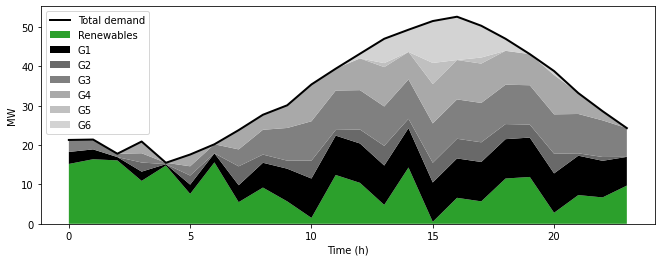

In [25]:
# Plot results
df = pd.DataFrame(abs(g.value), columns=['G1', 'G2', 'G3', 'G4', 'G5', 'G6'])
df.insert(0, 'Renewables', rt)

# Color palette
colors = ['tab:green', 'black', 'dimgray', 'gray', 'darkgrey', 'silver', 'lightgray']

# Plot results
fig, ax = plt.subplots(figsize = (11, 4))
ax.stackplot(np.arange(T), df.T, labels= df.columns, colors = colors)
plt.plot(dt, linewidth=2, c = 'k', label = 'Total demand')
plt.ylabel('MW')
plt.xlabel('Time (h)')
plt.legend()

plt.savefig('.\\plots\\part1_dispatch.pdf')

In [39]:
df[df <= .0001] = 0
df.index = range(1,len(df)+1)
print(round(df,2).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Renewables &     G1 &    G2 &     G3 &     G4 &    G5 &     G6 \\
\midrule
1  &        15.2 &   3.05 &  0.00 &   3.05 &   0.00 &  0.00 &   0.00 \\
2  &        16.4 &   2.50 &  0.00 &   2.50 &   0.00 &  0.00 &   0.00 \\
3  &        16.1 &   0.85 &  0.00 &   0.85 &   0.00 &  0.00 &   0.00 \\
4  &        10.9 &   2.35 &  2.32 &   2.35 &   2.98 &  0.00 &   0.00 \\
5  &        14.8 &   0.35 &  0.00 &   0.35 &   0.00 &  0.00 &   0.00 \\
6  &         7.6 &   2.35 &  2.31 &   2.35 &   2.99 &  0.00 &   0.00 \\
7  &        15.6 &   2.30 &  0.00 &   2.30 &   0.00 &  0.00 &   0.00 \\
8  &         5.5 &   4.30 &  4.80 &   4.30 &   4.90 &  0.00 &   0.00 \\
9  &         9.2 &   6.30 &  2.08 &   6.30 &   3.82 &  0.00 &   0.00 \\
10 &         5.7 &   8.30 &  2.04 &   8.30 &   5.76 &  0.00 &   0.00 \\
11 &         1.5 &  10.00 &  4.55 &  10.00 &   9.35 &  0.00 &   0.00 \\
12 &        12.4 &  10.00 &  1.45 &  10.00 &   5.55 &  0.00 &   0.00 \\
13 &        10.4 &  

# Question 1.2

In [40]:
# Define parameters
nu_d = 0.92
nu_c = 0.95
S_bar = 20

In [41]:
# Define variables
g = cp.Variable((T, N)) # Generator output
bc = cp.Variable((T, 1)) # Battery charge
bd = cp.Variable((T, 1)) # Battery discharged
S = cp.Variable((T+1, 1)) # Battery status

In [42]:
# Define objective
obj = cp.Minimize(sum(generation_costs@g.T))

In [43]:
# Define Constraints

# Non-neg contraints
cons = [g >= 0]
cons.append(S >= 0)
cons.append(bc >= 0)
cons.append(bd >= 0)

# Baundary conditions for the battery status
cons.append(S[0] == 0)
cons.append(S[-1] == 0)

# Battery capacity
cons.append(S <= S_bar)

# First time-step
cons.append( sum(g[0,:]) + rt[0] + bd[0] == dt[0] + bc[0]) # Dispatch
cons.append(S[1] == S[0] + bc[0]*nu_c - bd[0]/nu_d) # State of Battery

# Next T-1 time-steps
for t in range(1, T):
    cons.append(S[t + 1] == S[t] + bc[t]*nu_c - bd[t]/nu_d) # Dispatch
    cons.append( sum(g[t,:]) + rt[t] + bd[t] == dt[t] + bc[t]) # State of Battery
    cons.append( g[t,:] - g[t-1,:] <= ramp_up_rate) # Ramp up cons
    cons.append( g[t-1,:] - g[t,:] <= ramp_down_rate)# Ramp down cons

# For each generator i
for n in range(N):
    cons.append(g[:, n] <= capacity[n]) # Capacity cons

In [44]:
# Get results
# Solve
problem = cp.Problem(obj, cons)
problem.solve()

9777.67277022215

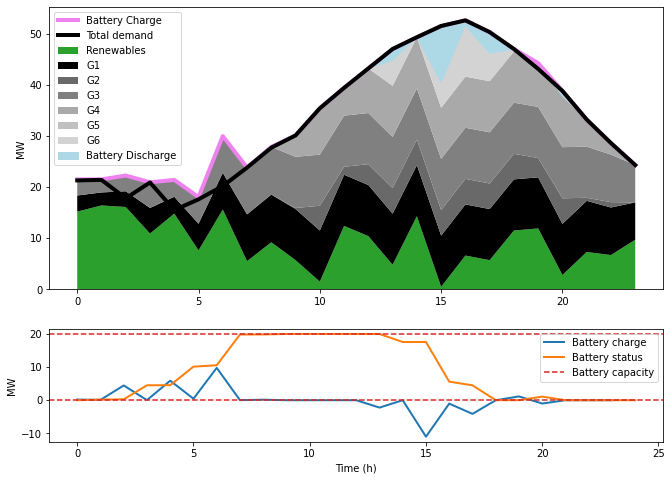

In [45]:
# Plot results
df = pd.DataFrame(abs(g.value), columns=['G1', 'G2', 'G3', 'G4', 'G5', 'G6'])
df.insert(0, 'Renewables', rt)
#df['Battery'] = np.maximum(bd.value- bc.value, 0)


fig, ax = plt.subplots(2, 1, figsize = (11, 8), gridspec_kw={'height_ratios': [2.5, 1]})
ax[0].stackplot(np.arange(T), df.T, labels = df.columns, colors = colors)
ax[0].plot(np.arange(T), np.maximum(df.sum(axis = 1), dt), c = 'violet', label = 'Battery Charge', linewidth=4)
ax[0].plot(dt, linewidth=4, c = 'k', label = 'Total demand')
ax[0].fill_between(np.arange(24), df.sum(axis = 1),dt,  where = (dt >= df.sum(axis = 1)), label = 'Battery Discharge',
                   color = 'lightblue', interpolate = True)

ax[0].set_ylabel('MW')
ax[0].legend()

ax[1].plot(bc.value - bd.value, label = 'Battery charge', linewidth=2)
ax[1].plot(S.value, label = 'Battery status', linewidth=2)
ax[1].axhline(20, linestyle = '--', c = 'tab:red', label = 'Battery capacity')
ax[1].axhline(0, linestyle = '--', c = 'tab:red')
ax[1].set_ylabel('MW')
ax[1].set_xlabel('Time (h)')
ax[1].legend()

plt.savefig('.\\plots\\part1_battery.pdf')

In [48]:
df['battery discharge'] = bd.value
df['battery charge'] = bc.value

df[df <= .0001] = 0
df.index = range(1,len(df)+1)
print(round(df,2).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  Renewables &     G1 &    G2 &     G3 &     G4 &   G5 &    G6 &  battery discharge &  battery charge \\
\midrule
1  &        15.2 &   3.15 &  0.00 &   3.15 &   0.00 &  0.0 &  0.00 &               0.00 &            0.19 \\
2  &        16.4 &   2.55 &  0.00 &   2.55 &   0.00 &  0.0 &  0.00 &               0.00 &            0.10 \\
3  &        16.1 &   3.08 &  0.00 &   3.08 &   0.00 &  0.0 &  0.00 &               0.00 &            4.46 \\
4  &        10.9 &   5.02 &  0.00 &   5.02 &   0.00 &  0.0 &  0.00 &               0.00 &            0.03 \\
5  &        14.8 &   3.30 &  0.00 &   3.30 &   0.00 &  0.0 &  0.00 &               0.00 &            5.89 \\
6  &         7.6 &   5.22 &  0.00 &   5.22 &   0.00 &  0.0 &  0.00 &               0.00 &            0.45 \\
7  &        15.6 &   7.18 &  0.00 &   7.18 &   0.00 &  0.0 &  0.00 &               0.00 &            9.77 \\
8  &         5.5 &   9.16 &  0.00 &   9.16 &   0.00 &  0.0 &  0.00 &              